In [ ]:
# Standard library imports.
from datetime import datetime, timedelta

# Related third party imports.
import requests
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
plt.rcParams["figure.figsize"] = (16,8)

# Local application/library specific imports.


# Download link traffic between firstDay and lastDay
# tuple, datetime, datetime -> ('bost-cr5','2/1/1'), datetime(2016,1,1,0,0,30), datetime(2016,2,1,0,0,0)
def download_link_traffic(link: tuple, start_date: datetime,
                          end_date: datetime) -> pd.DataFrame:
    # Empty list for the data
    traffic_data = []

    current_date = start_date
    while current_date < end_date:
        # The URL contains the link and time info.
        url = 'https://my.es.net/graphql?query={query:interface(device:"' + str(
            link[0]) + '",interface:"' + str(
                link[1]) + '"){traffic(beginTime:"' + current_date.isoformat(
                ) + '" endTime:"' + (current_date + timedelta(days=1)
                                     ).isoformat() + '"){points}}}&raw'

        # Downloading the data
        data = requests.get(url, verify=False)
        # Converting it to JSON
        json_data = data.json()

        if json_data['data']['query']['traffic']:
            # We have to go down some levels to get the data.
            # -> json_data['data']['query']['traffic']['points']
            traffic_data.extend(
                json_data['data']['query']['traffic']['points'])

        #moving to the next day
        current_date = current_date + timedelta(days=1)
    return pd.DataFrame(traffic_data, columns=['date', 'in', 'out'])

def changeDateFormat(df):
    # Oneliner to convert the UNIX timestamp to readable format
    func = lambda x: datetime.utcfromtimestamp(int(x)/1000).strftime('%Y-%m-%d %H:%M:%S')
    # Exchanging the timestamps
    df['date'] = df['date'].apply(func)
    return df

In [ ]:
def max_metric(preds, truth, max_boundary = 1):
  if(len(preds) != len(truth)):
    raise Exception('Incompatible input length!')
  
  sum_error = 0
  for i in range(0, len(preds)):
    if(abs(preds[i] - truth[i]) > max_boundary):
      sum_error += max_boundary
    else:
      sum_error += abs(preds[i] - truth[i])
  
  return sum_error / len(preds)

In [ ]:
link_list = [("cern-513-cr5", "to_cern_ip-a"), ("amst-cr5", "4/1/1"), ("amst-cr5", "4/2/1"), ("cern-773-cr5", "3/2/1"), ("cern-513-cr5", "6/2/1")]
a, b = datetime(2021,10,21,0,0,30), datetime(2021,10,29,0,0,0)
df = pd.DataFrame()

for i, curr_link in enumerate(link_list):
  curr_df = download_link_traffic(curr_link, a, b)
  curr_df = changeDateFormat(curr_df)
  curr_df = curr_df.drop_duplicates(subset=['date'])

  #curr_df.drop(['date'], axis=1, inplace=True)
  curr_df['in'].fillna(np.mean(curr_df['in']), inplace=True)
  curr_df['out'].fillna(np.mean(curr_df['out']), inplace=True)
  curr_df['in'] = curr_df['in']/10**9
  curr_df['out'] = curr_df['out']/10**9

  curr_df.rename(columns={'in': curr_link[0]+curr_link[1]+'-in', 'out': curr_link[0]+curr_link[1]+'-out'}, inplace=True)
  
  if(i == 0):
    df = pd.concat([df, curr_df], axis=1)
    continue

  df = pd.merge(df, curr_df, on='date', how='outer')

/usr/local/lib/python3.7/dist-packages/urllib3/connectionpool.py:847: InsecureRequestWarning: Unverified HTTPS request is being made. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#ssl-warnings
  InsecureRequestWarning)
/usr/local/lib/python3.7/dist-packages/urllib3/connectionpool.py:847: InsecureRequestWarning: Unverified HTTPS request is being made. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#ssl-warnings
  InsecureRequestWarning)
/usr/local/lib/python3.7/dist-packages/urllib3/connectionpool.py:847: InsecureRequestWarning: Unverified HTTPS request is being made. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#ssl-warnings
  InsecureRequestWarning)
/usr/local/lib/python3.7/dist-packages/urllib3/connectionpool.py:847: InsecureRequestWarning: Unverified HTTPS request is be

In [ ]:
df = df.sort_values(by=['date'])
df

,date,cern-513-cr5to_cern_ip-a-in,cern-513-cr5to_cern_ip-a-out,amst-cr54/1/1-in,amst-cr54/1/1-out,amst-cr54/2/1-in,amst-cr54/2/1-out,cern-773-cr53/2/1-in,cern-773-cr53/2/1-out,cern-513-cr56/2/1-in,cern-513-cr56/2/1-out
0,2021-10-21 00:00:30,0.233939,0.004208,23.509259,35.926879,1.139651,0.997098,12.881553,7.204921,0.000042,3.338055
1,2021-10-21 00:01:00,0.175804,0.001163,23.101380,37.792523,1.696950,1.113463,14.029378,7.409114,0.000044,3.090267
2,2021-10-21 00:01:30,0.255905,0.004395,24.744265,38.112942,2.062712,0.709236,12.355961,8.229614,0.000043,3.587920
3,2021-10-21 00:02:00,0.216990,0.001718,25.942120,43.093288,1.535902,0.758419,12.897446,7.074225,0.000051,3.536076
4,2021-10-21 00:02:30,0.200085,0.003697,25.721093,41.485464,1.575834,1.258086,12.398613,7.086922,0.000053,3.543057
...,...,...,...,...,...,...,...,...,...,...,...
22907,2021-10-28 23:58:30,0.018487,1.046916,16.146181,2.694857,1.055926,2.709698,0.185206,3.919510,2.571526,0.000142
22908,2021-10-28 23:59:00,0.017266,0.940767,17.019039,2.820801,1.611397,2.865629,0.206986,6.299098,2.057765,0.000059
22909,2021-10-28 23:59:30,0.016308,1.034508,16.983954,2.621843,1.169360,2.950316,0.245184,6.403442,0.806560,0.000092
22910,2021-10-29 00:00:00,0.012762,1.055736,16.389912,2.937878,0.573494,3.816393,0.265445,8.866797,2.093444,0.000055


In [ ]:
df.describe()

,cern-513-cr5to_cern_ip-a-in,cern-513-cr5to_cern_ip-a-out,amst-cr54/1/1-in,amst-cr54/1/1-out,amst-cr54/2/1-in,amst-cr54/2/1-out,cern-773-cr53/2/1-in,cern-773-cr53/2/1-out,cern-513-cr56/2/1-in,cern-513-cr56/2/1-out
count,22912.000000,22912.000000,23041.000000,23041.000000,23041.000000,23041.000000,22816.000000,22816.000000,22912.000000,22912.000000
mean,0.265269,0.351377,9.079673,16.056979,3.711550,1.190199,9.280940,7.593324,0.625788,1.724646
std,0.608499,0.246392,7.053382,11.368690,3.823508,2.055066,8.223755,5.267962,0.701656,1.844492
min,0.001314,0.001084,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000022,0.000039
25%,0.043219,0.209436,3.137521,5.938209,1.331121,0.088954,3.831880,3.795352,0.178485,0.430225
50%,0.076178,0.304311,8.136063,13.854902,2.474175,0.417295,6.901242,6.127690,0.385992,1.165078
75%,0.188505,0.427686,12.842669,24.845898,4.596661,1.441142,11.904467,9.984595,0.821758,2.368163
max,9.996675,4.856950,40.098408,78.717716,48.095662,25.015138,176.695453,47.320074,8.253315,26.548574


In [ ]:
cols_w_nulls = ['cern-513-cr5to_cern_ip-a-in', 'cern-513-cr5to_cern_ip-a-out', 'cern-773-cr53/2/1-in', 'cern-773-cr53/2/1-out',
                'cern-513-cr56/2/1-in',	'cern-513-cr56/2/1-out']

for col in cols_w_nulls:
  df[col].fillna(df[col].mean(), inplace=True)

df.describe()

,cern-513-cr5to_cern_ip-a-in,cern-513-cr5to_cern_ip-a-out,amst-cr54/1/1-in,amst-cr54/1/1-out,amst-cr54/2/1-in,amst-cr54/2/1-out,cern-773-cr53/2/1-in,cern-773-cr53/2/1-out,cern-513-cr56/2/1-in,cern-513-cr56/2/1-out
count,23041.000000,23041.000000,23041.000000,23041.000000,23041.000000,23041.000000,23041.000000,23041.000000,23041.000000,23041.000000
mean,0.265269,0.351377,9.079673,16.056979,3.711550,1.190199,9.280940,7.593324,0.625788,1.724646
std,0.606794,0.245701,7.053382,11.368690,3.823508,2.055066,8.183501,5.242177,0.699689,1.839322
min,0.001314,0.001084,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000022,0.000039
25%,0.043420,0.210081,3.137521,5.938209,1.331121,0.088954,3.855809,3.811008,0.179280,0.433336
50%,0.076434,0.305596,8.136063,13.854902,2.474175,0.417295,6.978942,6.191441,0.389331,1.175559
75%,0.194055,0.426532,12.842669,24.845898,4.596661,1.441142,11.825586,9.941052,0.816579,2.360501
max,9.996675,4.856950,40.098408,78.717716,48.095662,25.015138,176.695453,47.320074,8.253315,26.548574


<Figure size 432x288 with 0 Axes>

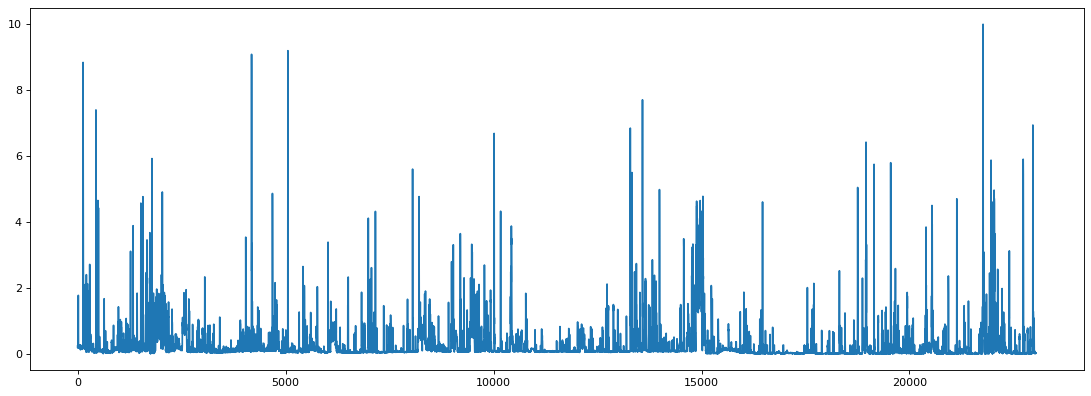

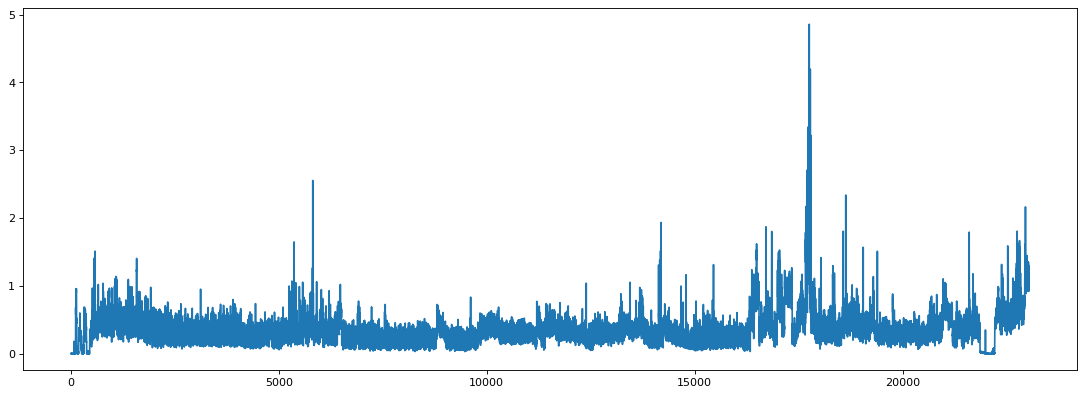

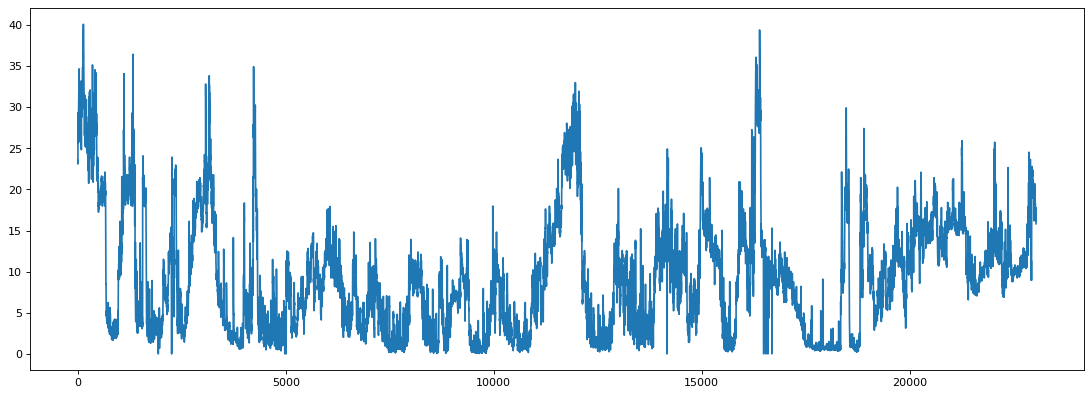

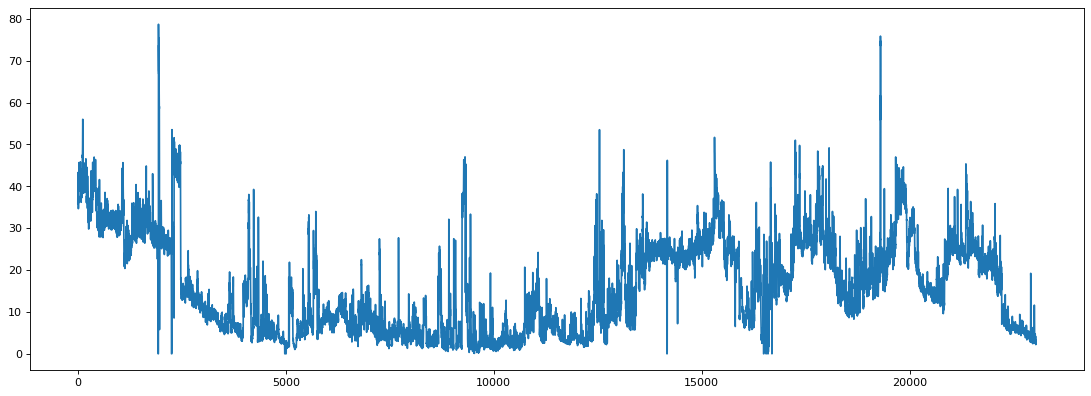

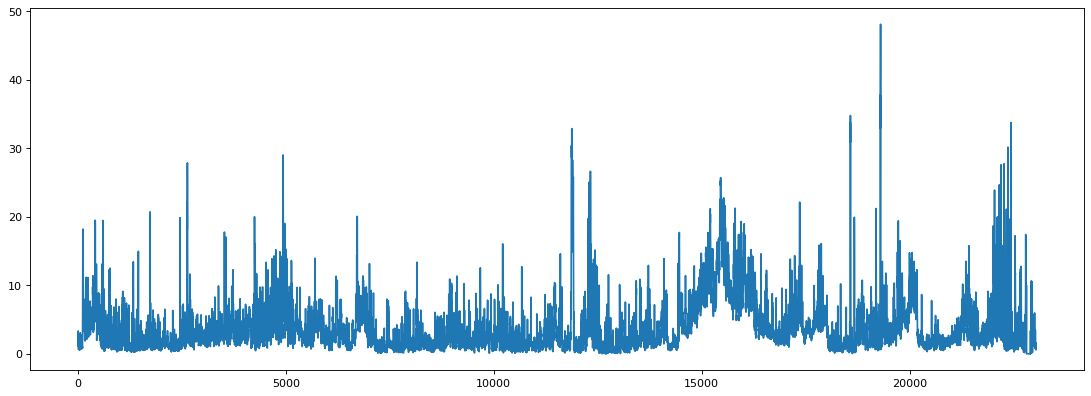

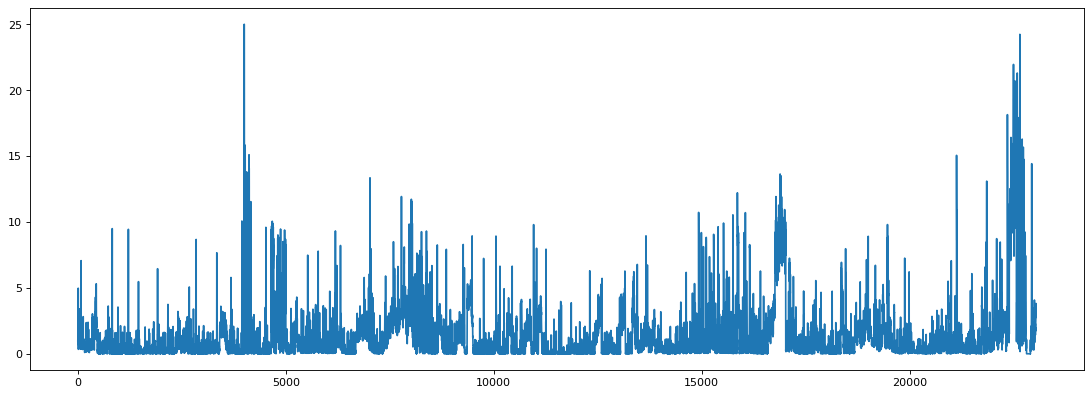

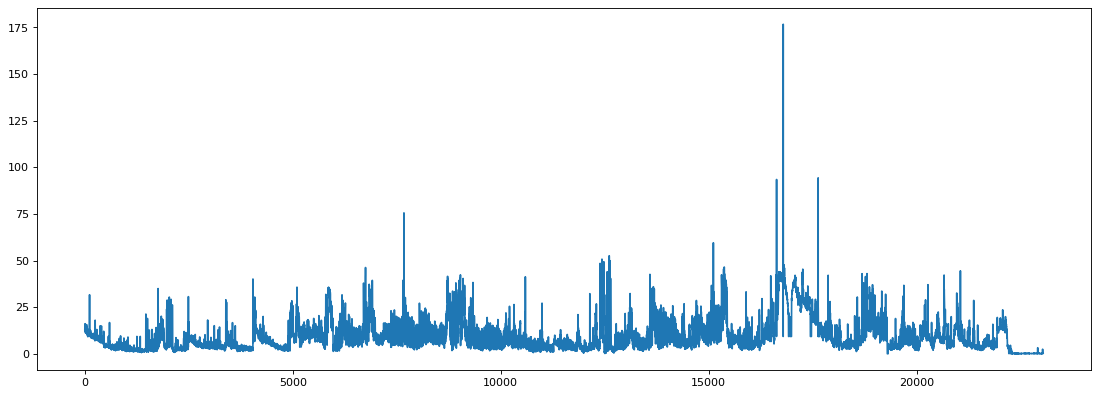

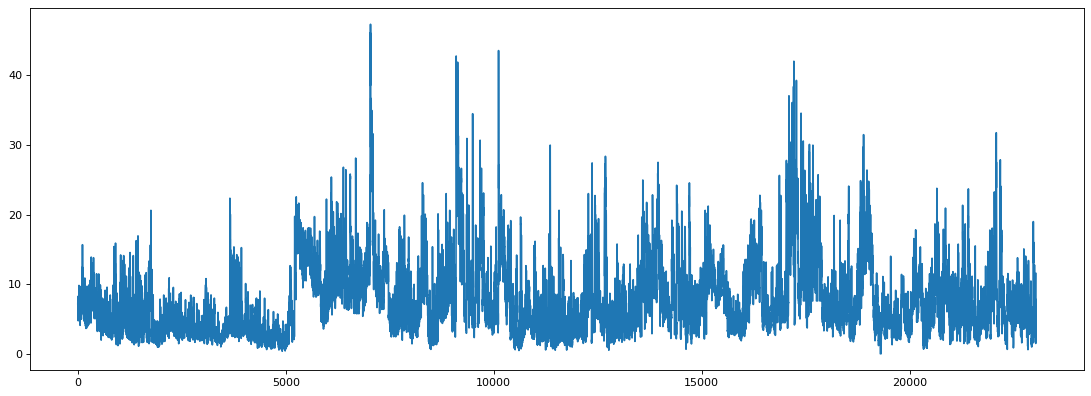

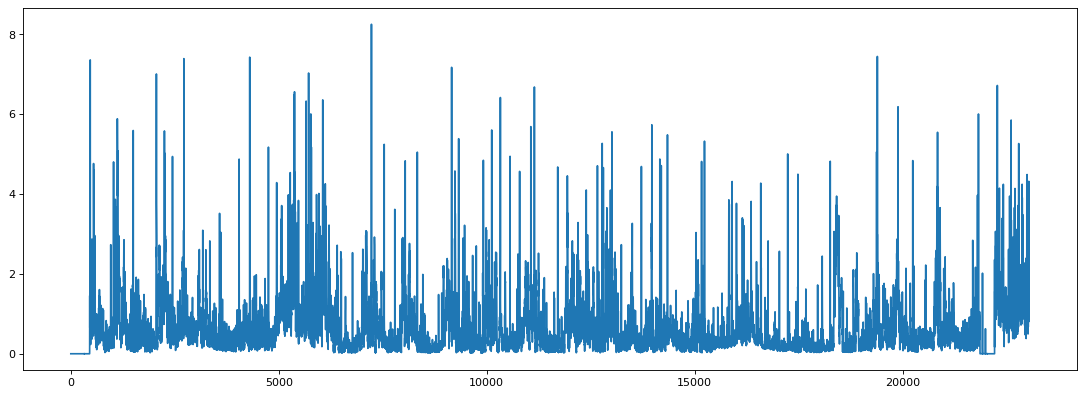

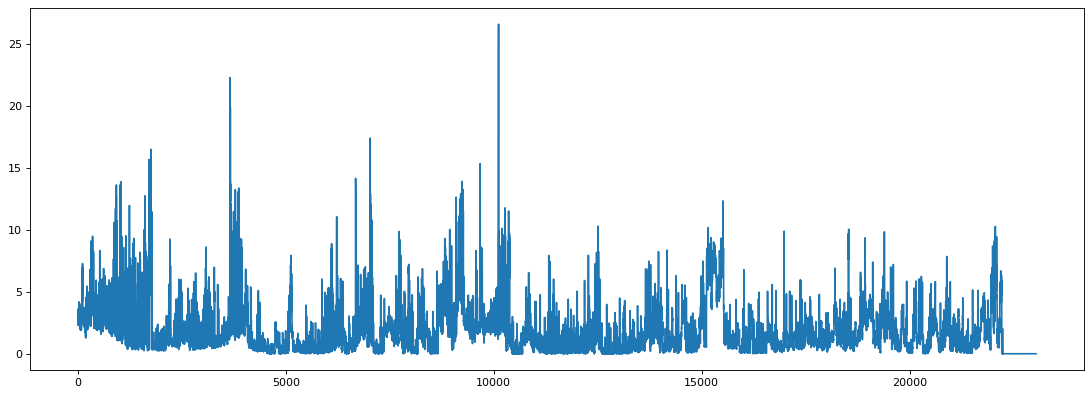

In [ ]:
from matplotlib.pyplot import figure

df = df.reset_index()
df.drop('index', axis=1, inplace=True)
for i, col in enumerate(df.columns):
  if(col == 'date'):
    continue

  plt.figure(i)
  figure(figsize=(17, 6), dpi=80)
  df[col].plot()

**Predicting**

In [ ]:
#df = df[:5000] # Kikapcsolt allapotok miatt
df = df[:20000] # Kikapcsolt allapotok miatt

In [ ]:
from sklearn.model_selection import train_test_split
dataset_train, dataset_test = train_test_split(df, test_size=0.1, shuffle=False)
dataset_train.drop(['date'], axis=1, inplace=True)
dataset_test.drop(['date'], axis=1, inplace=True)
print(dataset_train)

       cern-513-cr5to_cern_ip-a-in  ...  cern-513-cr56/2/1-out
0                         0.233939  ...               3.338055
1                         0.175804  ...               3.090267
2                         0.255905  ...               3.587920
3                         0.216990  ...               3.536076
4                         0.200085  ...               3.543057
...                            ...  ...                    ...
17995                     0.002114  ...               0.999331
17996                     0.001792  ...               1.188805
17997                     0.001869  ...               0.804500
17998                     0.002226  ...               0.801346
17999                     0.002038  ...               1.188913

[18000 rows x 10 columns]


In [ ]:
X_train = []
y_train = []
WINDOW_SIZE = 180

for i in range(WINDOW_SIZE,len(dataset_train)):
  X_train.append(dataset_train.iloc[i-WINDOW_SIZE:i].values)
  y_train.append(dataset_train.iloc[i])

X_train, y_train = np.array(X_train), np.array(y_train)
#X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))

In [ ]:
import keras
import keras.models
import keras.layers

model = keras.models.Sequential([
    keras.layers.LSTM(80, return_sequences=True, input_shape=[None, len(dataset_train.columns)]),
    #keras.layers.Dropout(0.2),
    #keras.layers.LSTM(60, return_sequences=True),
    #keras.layers.Dropout(0.2),
    keras.layers.LSTM(80),
    keras.layers.Dense(len(dataset_train.columns))
])

model.compile(optimizer = 'adam', loss = 'mean_squared_error')

In [ ]:
from tensorflow.keras.callbacks import EarlyStopping

early_stopping = EarlyStopping(patience=6)

In [ ]:
model.fit(X_train, y_train, epochs = 120, validation_split=0.2, callbacks=[early_stopping])

Epoch 1/120
446/446 [==============================] - 106s 230ms/step - loss: 14.3943 - val_loss: 19.4802
Epoch 2/120
446/446 [==============================] - 102s 229ms/step - loss: 4.3523 - val_loss: 10.6549
Epoch 3/120
446/446 [==============================] - 101s 227ms/step - loss: 2.9570 - val_loss: 8.3280
Epoch 4/120
446/446 [==============================] - 102s 228ms/step - loss: 2.5362 - val_loss: 6.6786
Epoch 5/120
446/446 [==============================] - 105s 235ms/step - loss: 2.3354 - val_loss: 6.1515
Epoch 6/120
446/446 [==============================] - 102s 229ms/step - loss: 2.2236 - val_loss: 5.4202
Epoch 7/120
446/446 [==============================] - 103s 230ms/step - loss: 2.1478 - val_loss: 5.5294
Epoch 8/120
446/446 [==============================] - 102s 229ms/step - loss: 2.0760 - val_loss: 5.2984
Epoch 9/120
446/446 [==============================] - 102s 229ms/step - loss: 2.0239 - val_loss: 5.0002
Epoch 10/120
446/446 [==============================

In [ ]:
test_set = dataset_train.iloc[-WINDOW_SIZE:]
test_set = pd.concat([test_set, dataset_test])
test_set

,cern-513-cr5to_cern_ip-a-in,cern-513-cr5to_cern_ip-a-out,amst-cr54/1/1-in,amst-cr54/1/1-out,amst-cr54/2/1-in,amst-cr54/2/1-out,cern-773-cr53/2/1-in,cern-773-cr53/2/1-out,cern-513-cr56/2/1-in,cern-513-cr56/2/1-out
17820,0.002776,0.452591,0.750117,37.823657,10.670309,0.363665,15.517649,17.036526,0.541516,0.540276
17821,0.002246,0.571863,0.801082,37.996866,12.054606,0.486059,14.393755,15.741902,0.274988,0.529183
17822,0.001947,0.572134,0.858430,38.741455,13.012677,0.307806,12.760474,17.286744,0.164260,0.648560
17823,0.003785,0.500184,0.977018,34.054835,13.566561,0.273492,15.441616,17.484592,0.090152,1.107275
17824,0.002276,0.515300,0.875826,37.004544,14.197445,0.265720,15.536060,15.592275,0.376544,0.731402
...,...,...,...,...,...,...,...,...,...,...
19995,0.054386,0.387991,11.894783,26.936659,8.135226,0.188030,5.632476,3.654594,1.546903,0.062615
19996,0.146948,0.359041,10.438351,27.084509,8.770182,0.127706,5.564955,4.002445,0.862347,0.065928
19997,0.846153,0.279608,10.893182,27.573940,8.791793,0.124025,3.463116,3.654443,0.616082,0.070215
19998,0.814100,0.372761,11.275566,27.114040,10.422748,0.118193,2.398176,3.193486,0.559515,0.079424


In [ ]:
X_test = []

for i in range(WINDOW_SIZE,len(test_set)):
  X_test.append(test_set.iloc[i-WINDOW_SIZE:i].values)

X_test = np.array(X_test)

In [ ]:
preds = model.predict(X_test)

In [ ]:
link_names_inorder = list(dataset_test.columns.values)
link_names_inorder

['cern-513-cr5to_cern_ip-a-in',
 'cern-513-cr5to_cern_ip-a-out',
 'amst-cr54/1/1-in',
 'amst-cr54/1/1-out',
 'amst-cr54/2/1-in',
 'amst-cr54/2/1-out',
 'cern-773-cr53/2/1-in',
 'cern-773-cr53/2/1-out',
 'cern-513-cr56/2/1-in',
 'cern-513-cr56/2/1-out']

<Figure size 432x288 with 0 Axes>

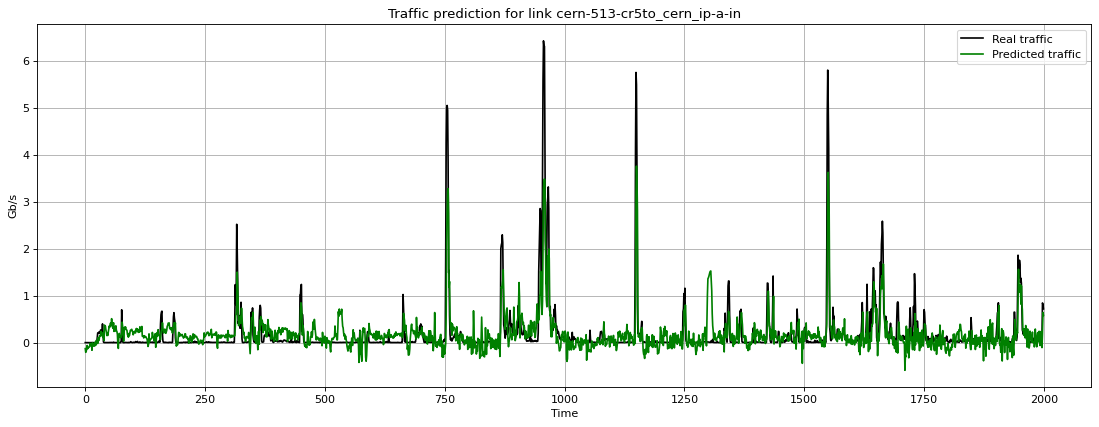

<Figure size 432x288 with 0 Axes>

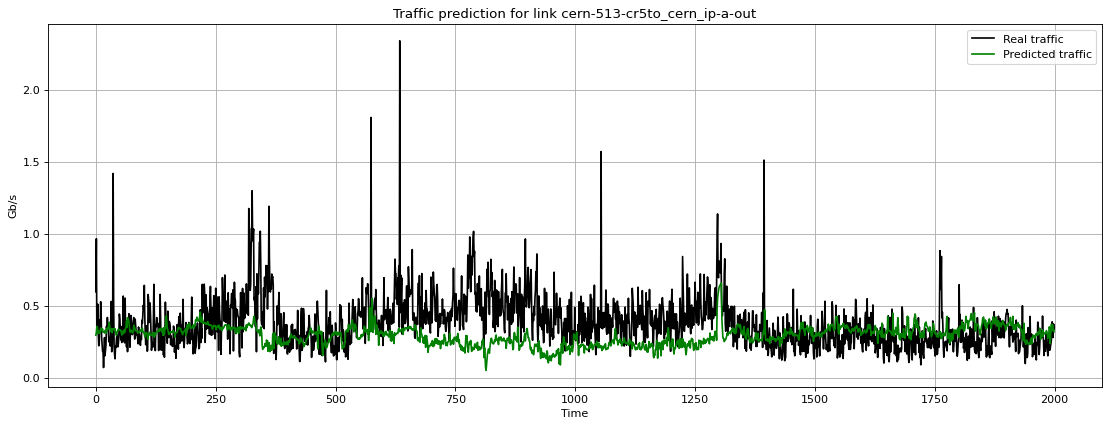

<Figure size 432x288 with 0 Axes>

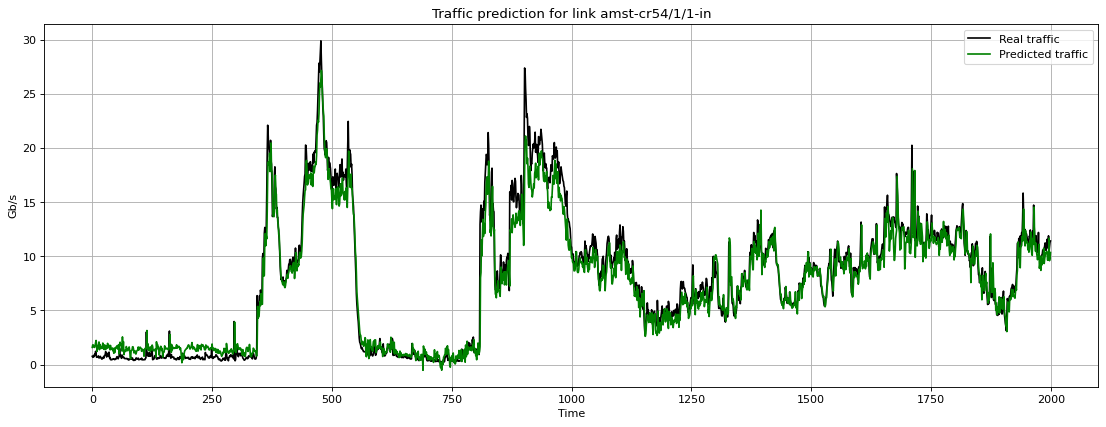

<Figure size 432x288 with 0 Axes>

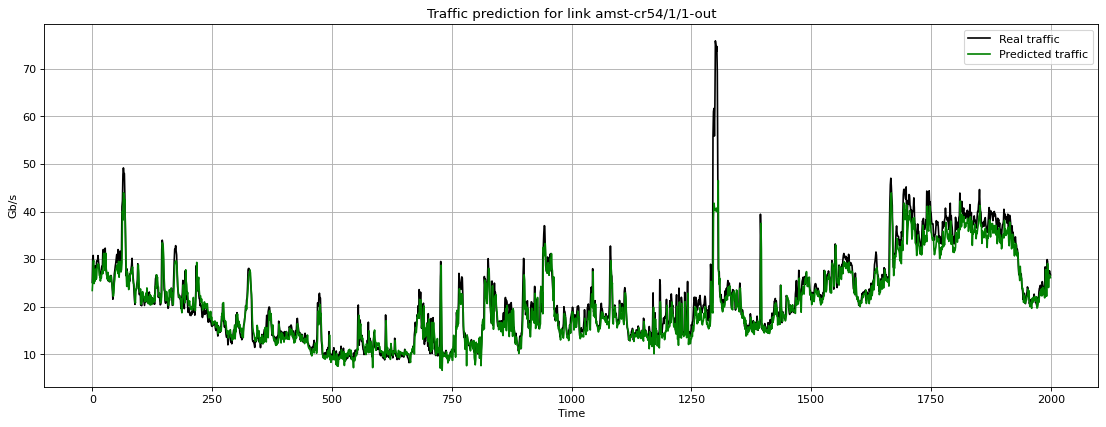

<Figure size 432x288 with 0 Axes>

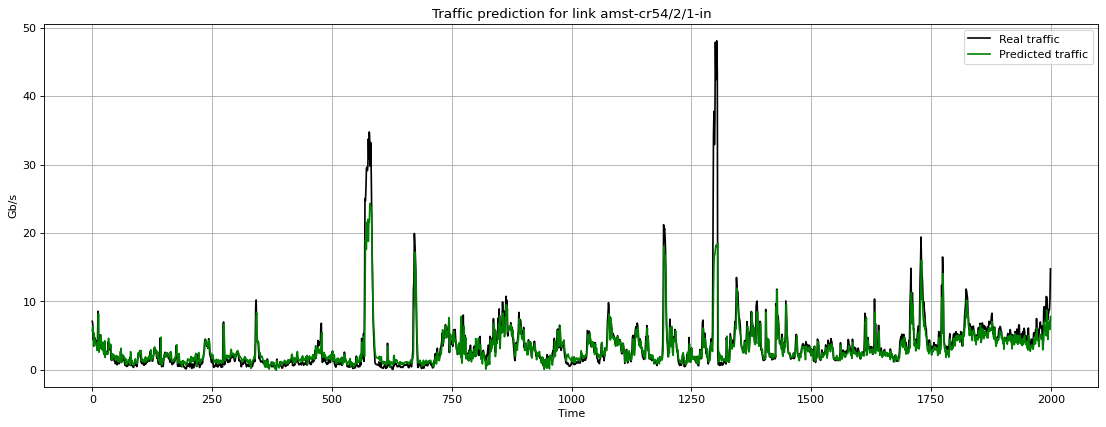

<Figure size 432x288 with 0 Axes>

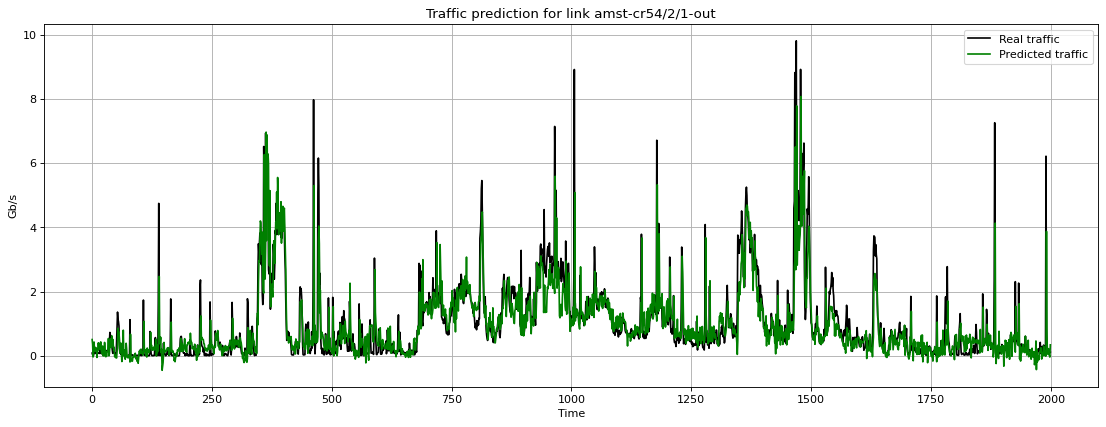

<Figure size 432x288 with 0 Axes>

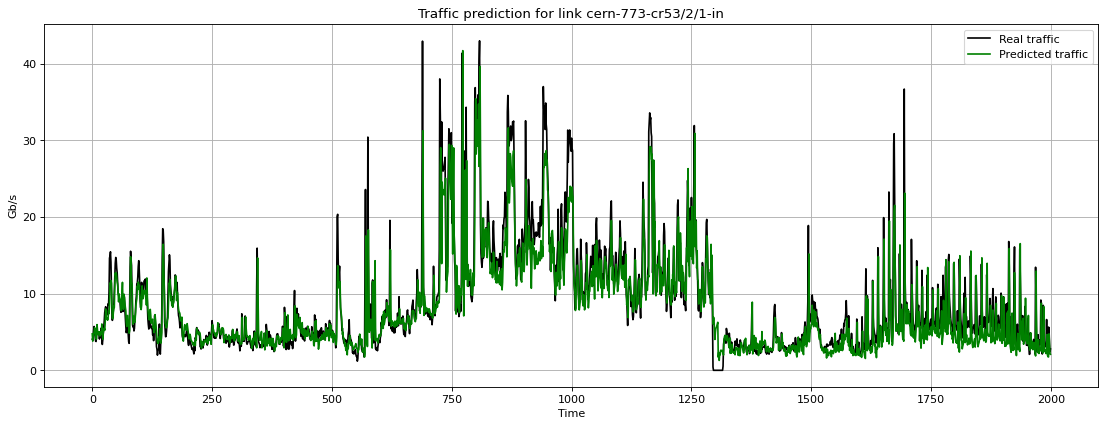

<Figure size 432x288 with 0 Axes>

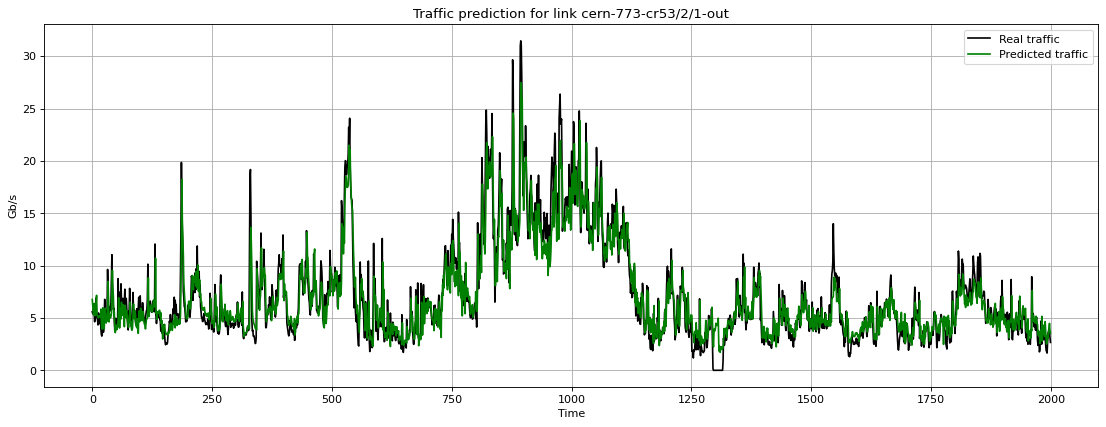

<Figure size 432x288 with 0 Axes>

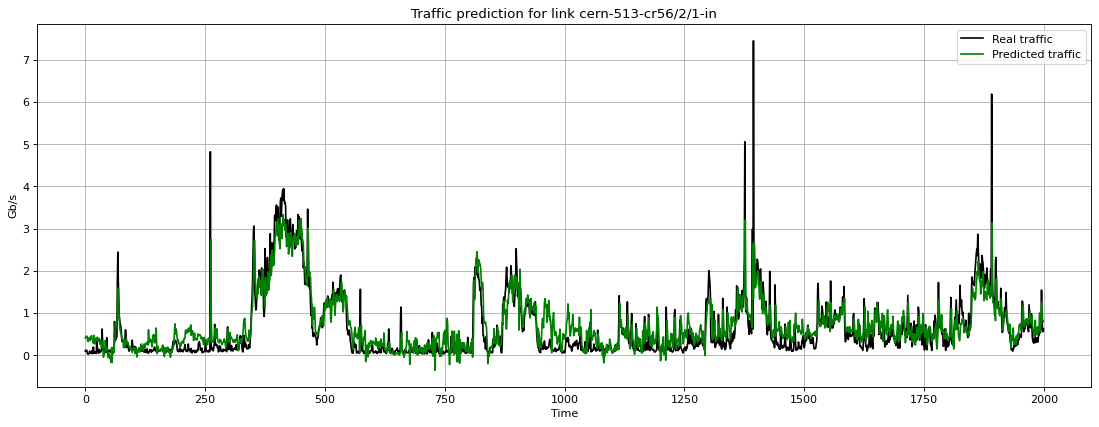

<Figure size 432x288 with 0 Axes>

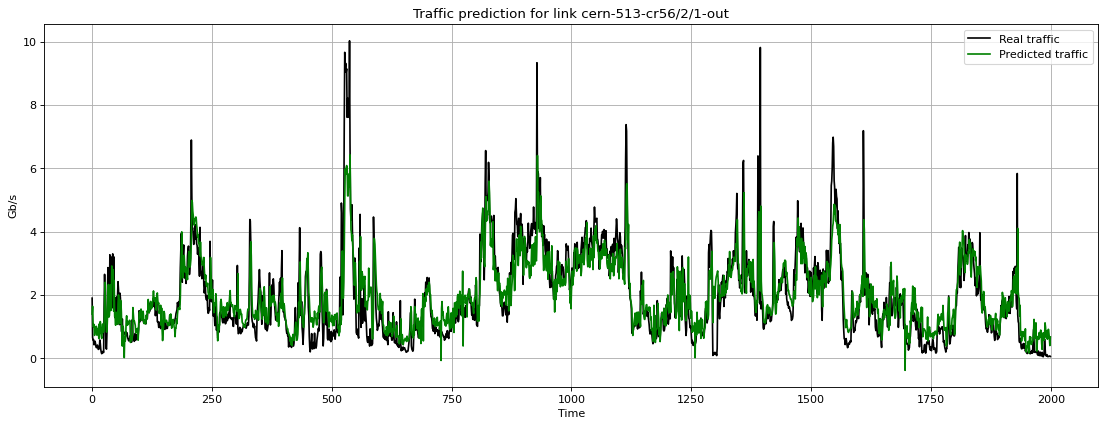

In [ ]:
dataset_test = dataset_test.reset_index()
dataset_test.drop(['index'], axis=1, inplace=True)
for i, col in enumerate(dataset_test.columns):

  curr_preds = []
  for val in preds:
    curr_preds.append(val[i])


  plt.figure(i)
  figure(figsize=(17, 6), dpi=80)
  plt.plot(dataset_test[col], color = 'black', label = 'Real traffic')
  plt.plot(curr_preds, color = 'green', label = 'Predicted traffic')
  plt.title('Traffic prediction for link ' + col)
  plt.xlabel('Time')
  plt.ylabel('Gb/s')
  plt.legend()
  plt.grid()
  plt.show()

In [ ]:
class color:
   PURPLE = '\033[95m'
   CYAN = '\033[96m'
   DARKCYAN = '\033[36m'
   BLUE = '\033[94m'
   GREEN = '\033[92m'
   YELLOW = '\033[93m'
   RED = '\033[91m'
   BOLD = '\033[1m'
   UNDERLINE = '\033[4m'
   END = '\033[0m'

In [ ]:
from sklearn.metrics import mean_squared_error

for i, col in enumerate(dataset_test.columns):


  curr_preds = []
  for val in preds:
    curr_preds.append(val[i])
  
  total_error = 0
  curr_error = mean_squared_error(dataset_test[col], curr_preds)
  total_error += curr_error
  print(col, ' error: ', curr_error)

print(color.BOLD , 'Mean error: ' , total_error/len(dataset_test.columns) , color.END)

cern-513-cr5to_cern_ip-a-in  error:  0.14168928232515557
cern-513-cr5to_cern_ip-a-out  error:  0.04433632090601127
amst-cr54/1/1-in  error:  1.8362010248981078
amst-cr54/1/1-out  error:  10.433525012051236
amst-cr54/2/1-in  error:  5.349979301596994
amst-cr54/2/1-out  error:  0.5602185084704162
cern-773-cr53/2/1-in  error:  10.635901816291415
cern-773-cr53/2/1-out  error:  3.318949150229075
cern-513-cr56/2/1-in  error:  0.16243799660727484
cern-513-cr56/2/1-out  error:  0.5485596468807484
 Mean error:  0.05485596468807484 


In [ ]:
for j, col in enumerate(dataset_test.columns):
  curr_preds = []
  for val in preds:
    curr_preds.append(val[j])
  
  sum_error = 0
  curr_error = max_metric(curr_preds, dataset_test[col], 1)
  sum_error += curr_error

  print(col, ' max_error: ', curr_error)

print(color.BOLD , 'Mean max_error: ' , sum_error/len(dataset_test.columns) , color.END)

cern-513-cr5to_cern_ip-a-in  max_error:  0.1877783691760222
cern-513-cr5to_cern_ip-a-out  max_error:  0.15099793974680953
amst-cr54/1/1-in  max_error:  0.6442271700570646
amst-cr54/1/1-out  max_error:  0.7690202368507212
amst-cr54/2/1-in  max_error:  0.5805618333893454
amst-cr54/2/1-out  max_error:  0.32222488320093395
cern-773-cr53/2/1-in  max_error:  0.7543610992110155
cern-773-cr53/2/1-out  max_error:  0.6939859067885704
cern-513-cr56/2/1-in  max_error:  0.25493023195567976
cern-513-cr56/2/1-out  max_error:  0.43522436249157637
 Mean max_error:  0.04352243624915764 


Naive approach

In [ ]:
for i, col in enumerate(dataset_test.columns):

  curr_preds = dataset_test[col][:-1]
  truth = dataset_test[col][1:]

  sum_error = 0
  curr_error = max_metric(curr_preds.array, truth.array, 1)
  sum_error += curr_error

  print(col, ' max_error: ', curr_error)

print(color.BOLD , 'Mean max_error: ' , sum_error/len(dataset_test.columns) , color.END)


cern-513-cr5to_cern_ip-a-in  max_error:  0.07069643523638024
cern-513-cr5to_cern_ip-a-out  max_error:  0.10793452779048326
amst-cr54/1/1-in  max_error:  0.39995352358966224
amst-cr54/1/1-out  max_error:  0.701582939043656
amst-cr54/2/1-in  max_error:  0.46446597396931755
amst-cr54/2/1-out  max_error:  0.23324415469347992
cern-773-cr53/2/1-in  max_error:  0.6603490290401207
cern-773-cr53/2/1-out  max_error:  0.6318822845781547
cern-513-cr56/2/1-in  max_error:  0.1391608391578505
cern-513-cr56/2/1-out  max_error:  0.27924177157802466
 Mean max_error:  0.027924177157802467 


In [ ]:
for i, col in enumerate(dataset_test.columns):

  curr_preds = dataset_test[col][:-1]
  truth = dataset_test[col][1:]

  sum_error = 0
  curr_error = mean_squared_error(truth, curr_preds)
  sum_error += curr_error

  print(col, ' error: ', curr_error)

print(color.BOLD , 'Mean error: ' , sum_error/len(dataset_test.columns) , color.END)

cern-513-cr5to_cern_ip-a-in  error:  0.06830252591094577
cern-513-cr5to_cern_ip-a-out  error:  0.028020531490100337
amst-cr54/1/1-in  error:  0.8016416779092317
amst-cr54/1/1-out  error:  5.307609073793652
amst-cr54/2/1-in  error:  2.818935973220333
amst-cr54/2/1-out  error:  0.5450453147942056
cern-773-cr53/2/1-in  error:  9.436632348941517
cern-773-cr53/2/1-out  error:  2.7385019071889336
cern-513-cr56/2/1-in  error:  0.14306620912841544
cern-513-cr56/2/1-out  error:  0.38078449921709245
 Mean error:  0.038078449921709244 


**Links connecting to one particular node**

CERN-513

In [ ]:
link_list = [("cern-513-cr5", "to_cern_ip-a"), ("amst-cr5", "4/1/1"), ("cern-513-cr5", "6/2/1"), ("cern-513-cr5", "1/1/1")]
a, b = datetime(2021,10,21,0,0,30), datetime(2021,10,29,0,0,0)
df = pd.DataFrame()

for i, curr_link in enumerate(link_list):
  curr_df = download_link_traffic(curr_link, a, b)
  curr_df = changeDateFormat(curr_df)
  curr_df = curr_df.drop_duplicates(subset=['date'])

  #curr_df.drop(['date'], axis=1, inplace=True)
  curr_df['in'].fillna(np.mean(curr_df['in']), inplace=True)
  curr_df['out'].fillna(np.mean(curr_df['out']), inplace=True)
  curr_df['in'] = curr_df['in']/10**9
  curr_df['out'] = curr_df['out']/10**9

  curr_df.rename(columns={'in': curr_link[0]+curr_link[1]+'-in', 'out': curr_link[0]+curr_link[1]+'-out'}, inplace=True)
  
  if(i == 0):
    df = pd.concat([df, curr_df], axis=1)
    continue

  df = pd.merge(df, curr_df, on='date', how='outer')

/usr/local/lib/python3.7/dist-packages/urllib3/connectionpool.py:847: InsecureRequestWarning: Unverified HTTPS request is being made. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#ssl-warnings
  InsecureRequestWarning)
/usr/local/lib/python3.7/dist-packages/urllib3/connectionpool.py:847: InsecureRequestWarning: Unverified HTTPS request is being made. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#ssl-warnings
  InsecureRequestWarning)
/usr/local/lib/python3.7/dist-packages/urllib3/connectionpool.py:847: InsecureRequestWarning: Unverified HTTPS request is being made. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#ssl-warnings
  InsecureRequestWarning)
/usr/local/lib/python3.7/dist-packages/urllib3/connectionpool.py:847: InsecureRequestWarning: Unverified HTTPS request is be

In [ ]:
df = df.sort_values(by=['date'])

cols_w_nulls = ['cern-513-cr5to_cern_ip-a-in', 'cern-513-cr5to_cern_ip-a-out', 'cern-513-cr51/1/1-in', 'cern-513-cr51/1/1-out',
                'cern-513-cr56/2/1-in',	'cern-513-cr56/2/1-out']

for col in cols_w_nulls:
  df[col].fillna(df[col].mean(), inplace=True)

df.describe()

,cern-513-cr5to_cern_ip-a-in,cern-513-cr5to_cern_ip-a-out,amst-cr54/1/1-in,amst-cr54/1/1-out,cern-513-cr56/2/1-in,cern-513-cr56/2/1-out,cern-513-cr51/1/1-in,cern-513-cr51/1/1-out
count,23041.000000,23041.000000,23041.000000,23041.000000,23041.000000,23041.000000,23041.000000,23041.000000
mean,0.265269,0.351377,9.079673,16.056979,0.625788,1.724646,13.685442,14.665992
std,0.606794,0.245701,7.053382,11.368690,0.699689,1.839322,9.607035,10.089388
min,0.001314,0.001084,0.000000,0.000000,0.000022,0.000039,0.000000,0.000000
25%,0.043420,0.210081,3.137521,5.938209,0.179280,0.433336,8.138673,8.661436
50%,0.076434,0.305596,8.136063,13.854902,0.389331,1.175559,11.781649,12.304535
75%,0.194055,0.426532,12.842669,24.845898,0.816579,2.360501,16.265678,17.607381
max,9.996675,4.856950,40.098408,78.717716,8.253315,26.548574,190.177644,118.030824


<Figure size 432x288 with 0 Axes>

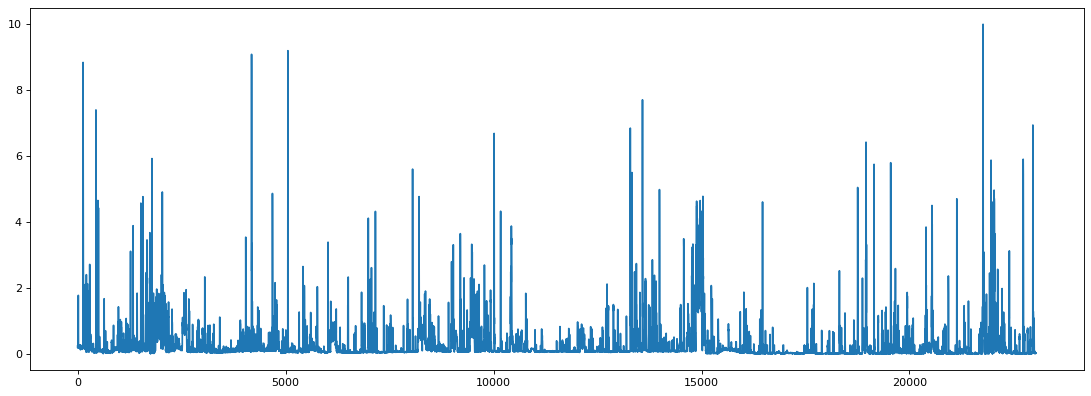

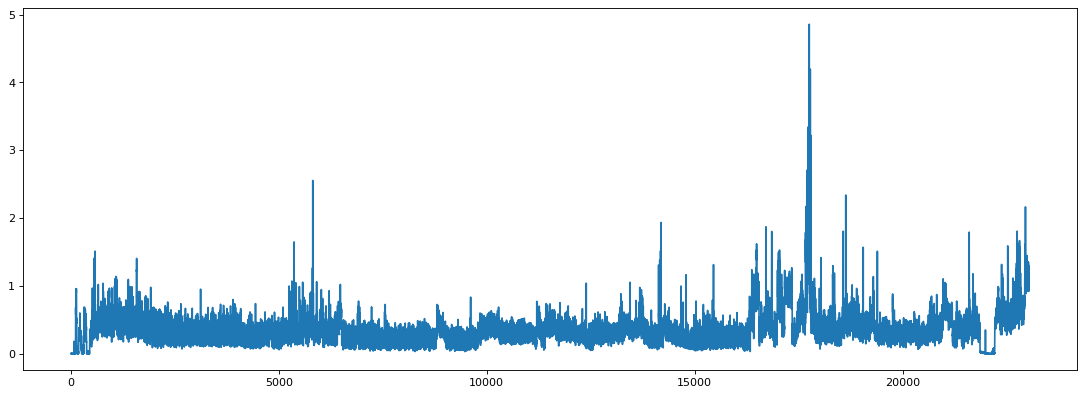

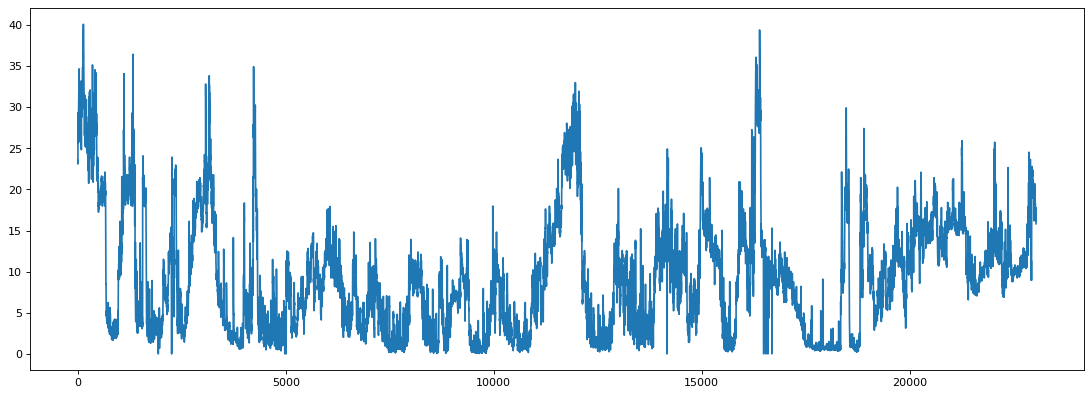

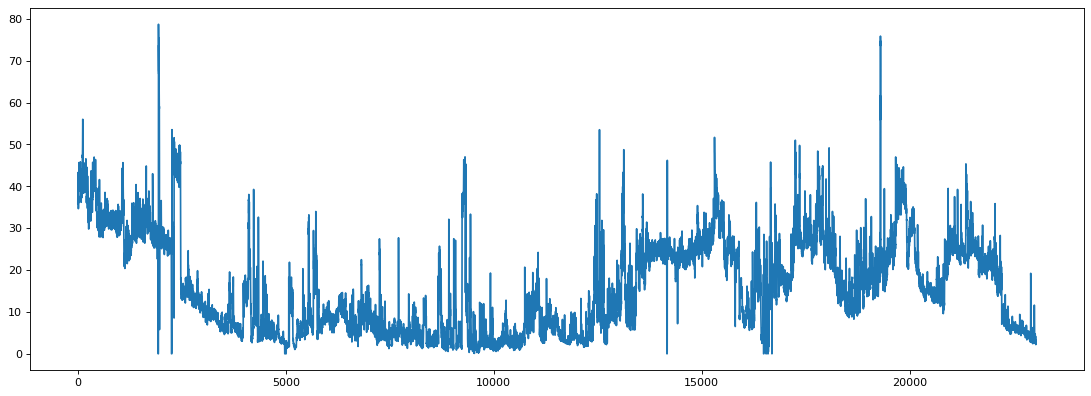

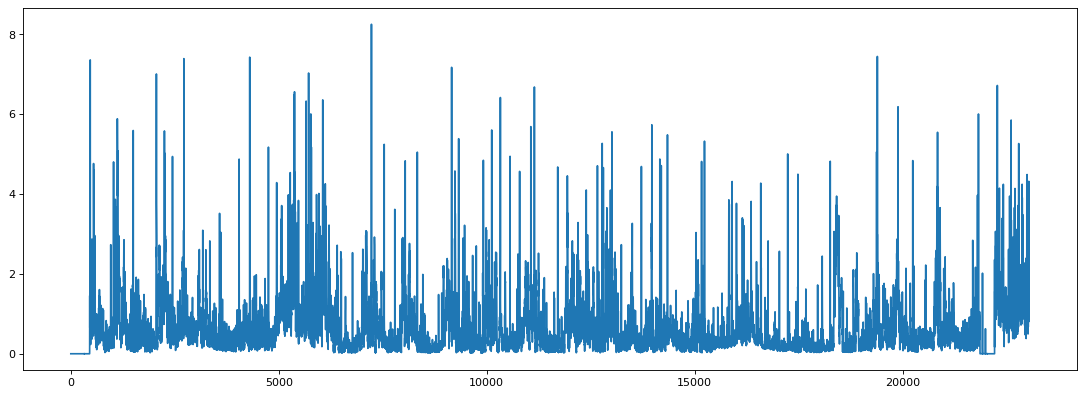

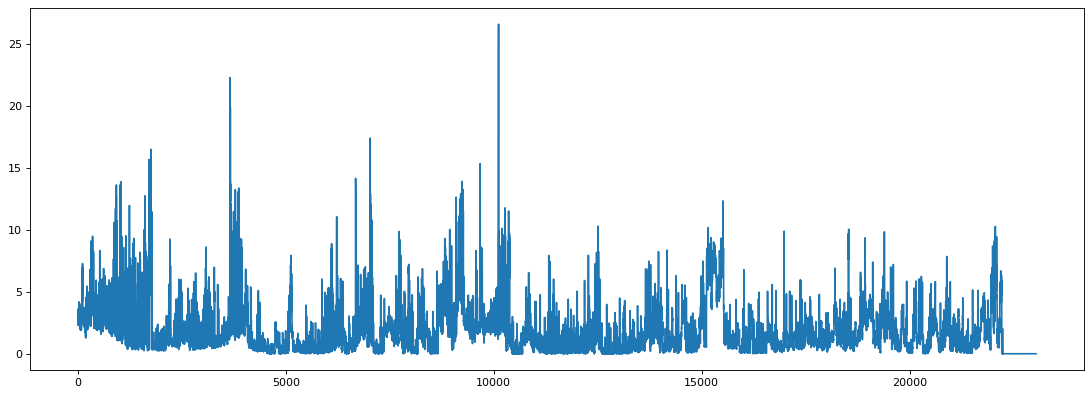

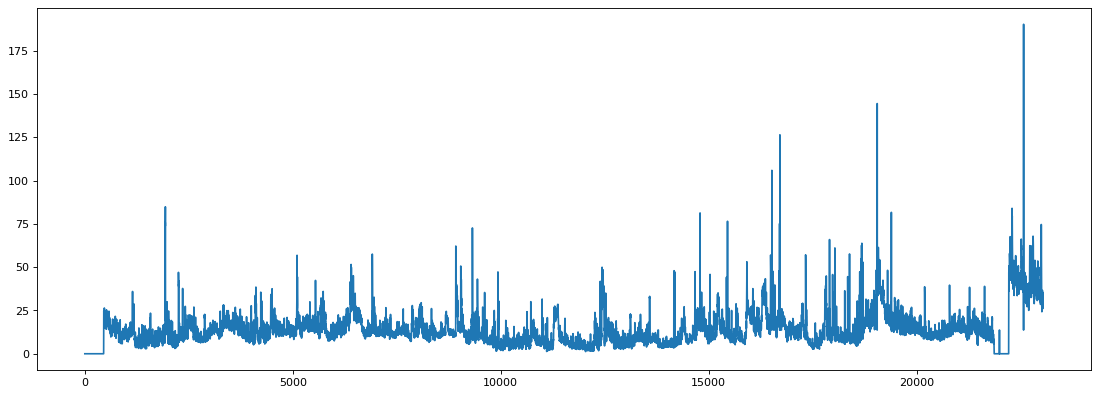

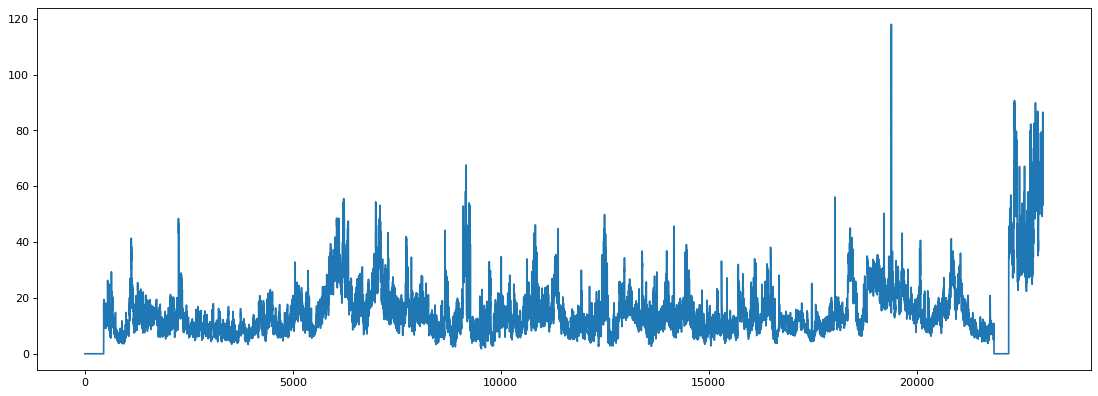

In [ ]:
from matplotlib.pyplot import figure

df = df.reset_index()
df.drop('index', axis=1, inplace=True)
for i, col in enumerate(df.columns):
  if(col == 'date'):
    continue

  plt.figure(i)
  figure(figsize=(17, 6), dpi=80)
  df[col].plot()

In [ ]:
df = df[:20000] # Kikapcsolt allapotok miatt

from sklearn.model_selection import train_test_split
dataset_train, dataset_test = train_test_split(df, test_size=0.1, shuffle=False)
dataset_train.drop(['date'], axis=1, inplace=True)
dataset_test.drop(['date'], axis=1, inplace=True)
print(dataset_train)

       cern-513-cr5to_cern_ip-a-in  ...  cern-513-cr51/1/1-out
0                         0.233939  ...               0.000000
1                         0.175804  ...               0.000000
2                         0.255905  ...               0.000000
3                         0.216990  ...               0.000000
4                         0.200085  ...               0.000000
...                            ...  ...                    ...
17995                     0.002114  ...              10.914591
17996                     0.001792  ...              10.684452
17997                     0.001869  ...              10.160118
17998                     0.002226  ...              11.094008
17999                     0.002038  ...              11.180003

[18000 rows x 8 columns]


/usr/local/lib/python3.7/dist-packages/pandas/core/frame.py:4174: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


In [ ]:
X_train = []
y_train = []
WINDOW_SIZE = 180

for i in range(WINDOW_SIZE,len(dataset_train)):
  X_train.append(dataset_train.iloc[i-WINDOW_SIZE:i].values)
  y_train.append(dataset_train.iloc[i])

X_train, y_train = np.array(X_train), np.array(y_train)

In [ ]:
import keras
import keras.models
import keras.layers
from tensorflow.keras.callbacks import EarlyStopping

model = keras.models.Sequential([
    keras.layers.LSTM(80, return_sequences=True, input_shape=[None, len(dataset_train.columns)]),
    #keras.layers.Dropout(0.2),
    #keras.layers.LSTM(60, return_sequences=True),
    #keras.layers.Dropout(0.2),
    keras.layers.LSTM(80),
    keras.layers.Dense(len(dataset_train.columns))
])

model.compile(optimizer = 'adam', loss = 'mean_squared_error')

early_stopping = EarlyStopping(patience=6)

model.fit(X_train, y_train, epochs = 120, validation_split=0.2, callbacks=[early_stopping])

Epoch 1/120
446/446 [==============================] - 110s 240ms/step - loss: 25.8530 - val_loss: 16.1088
Epoch 2/120
446/446 [==============================] - 105s 235ms/step - loss: 7.6248 - val_loss: 8.4131
Epoch 3/120
446/446 [==============================] - 106s 238ms/step - loss: 4.5695 - val_loss: 6.3564
Epoch 4/120
446/446 [==============================] - 118s 264ms/step - loss: 3.5627 - val_loss: 5.7172
Epoch 5/120
446/446 [==============================] - 115s 259ms/step - loss: 3.1228 - val_loss: 5.1381
Epoch 6/120
446/446 [==============================] - 106s 238ms/step - loss: 2.9135 - val_loss: 4.7622
Epoch 7/120
446/446 [==============================] - 109s 243ms/step - loss: 2.7693 - val_loss: 4.8245
Epoch 8/120
446/446 [==============================] - 108s 241ms/step - loss: 2.6787 - val_loss: 4.5624
Epoch 9/120
446/446 [==============================] - 107s 241ms/step - loss: 2.6237 - val_loss: 4.6019
Epoch 10/120
446/446 [==============================]

In [ ]:
test_set = dataset_train.iloc[-WINDOW_SIZE:]
test_set = pd.concat([test_set, dataset_test])


X_test = []
for i in range(WINDOW_SIZE,len(test_set)):
  X_test.append(test_set.iloc[i-WINDOW_SIZE:i].values)

X_test = np.array(X_test)

In [ ]:
preds = model.predict(X_test)

<Figure size 432x288 with 0 Axes>

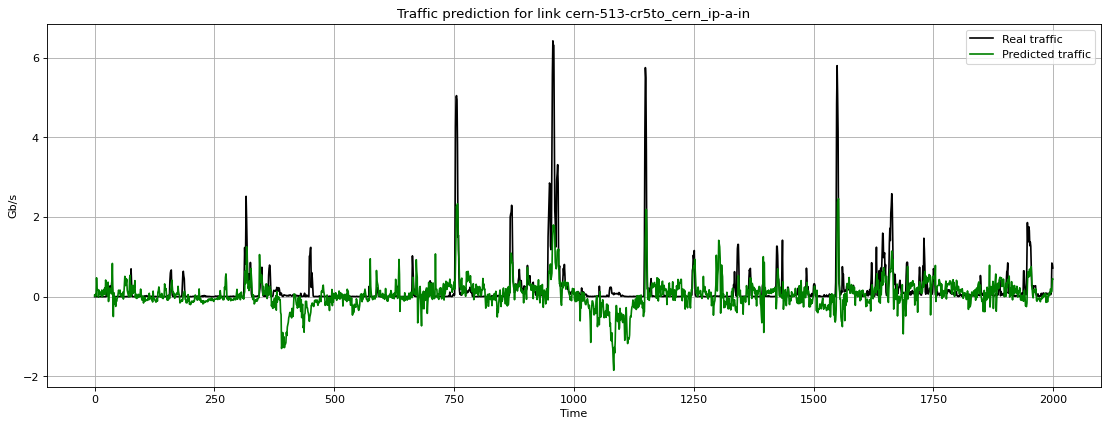

<Figure size 432x288 with 0 Axes>

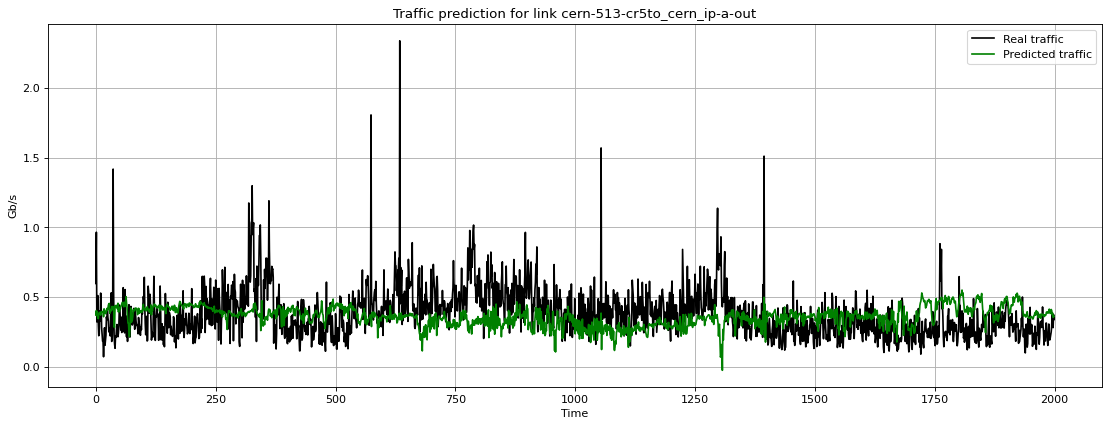

<Figure size 432x288 with 0 Axes>

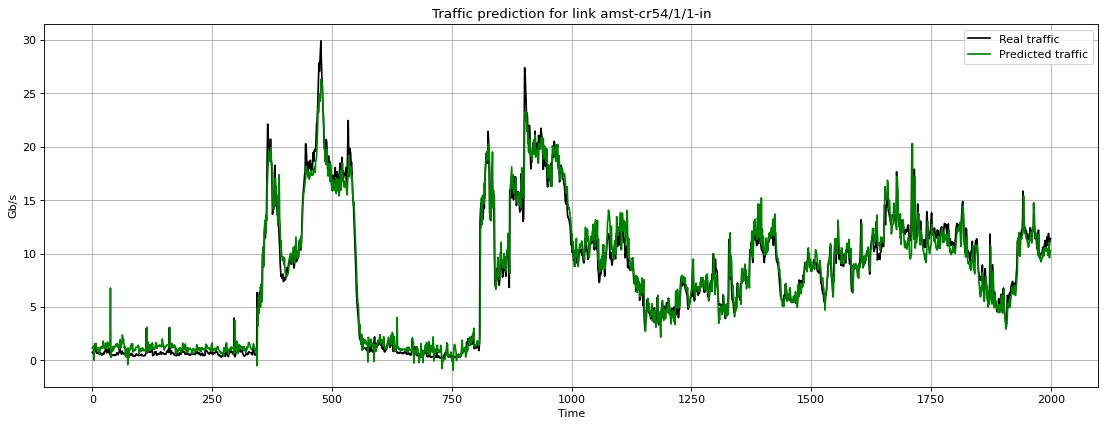

<Figure size 432x288 with 0 Axes>

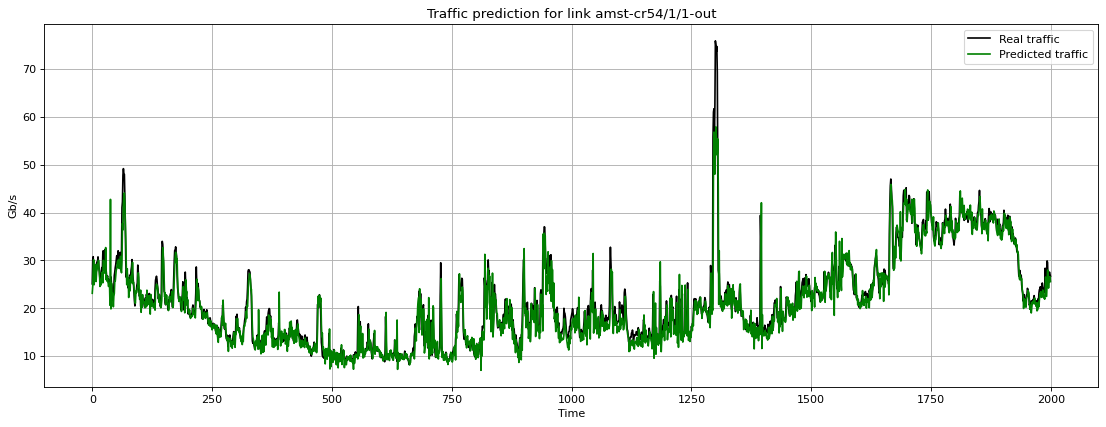

<Figure size 432x288 with 0 Axes>

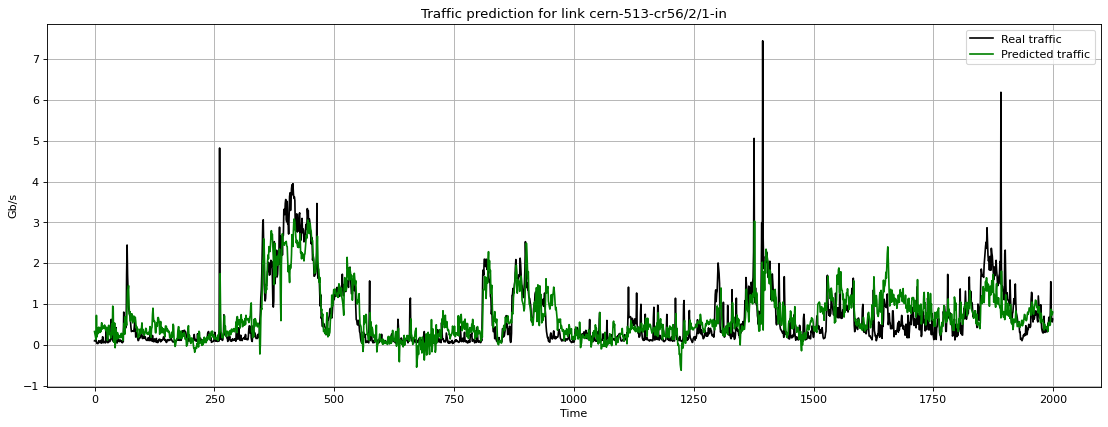

<Figure size 432x288 with 0 Axes>

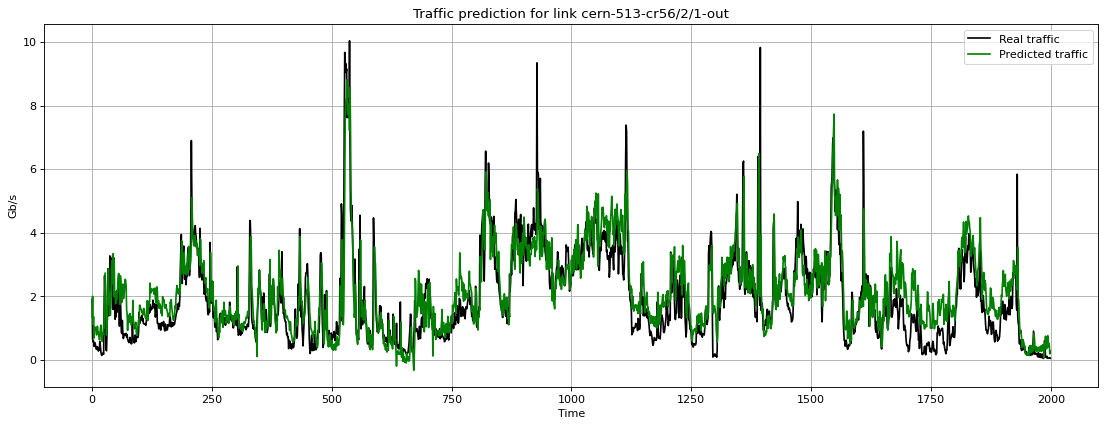

<Figure size 432x288 with 0 Axes>

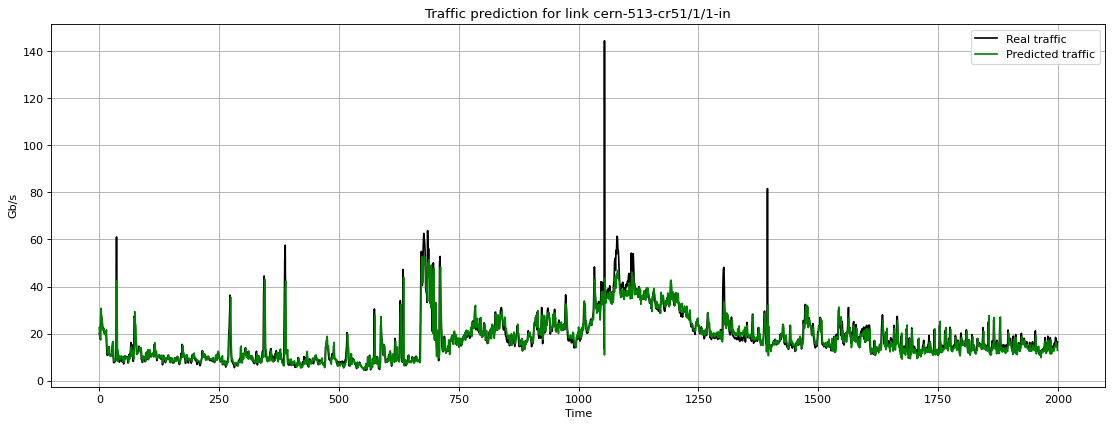

<Figure size 432x288 with 0 Axes>

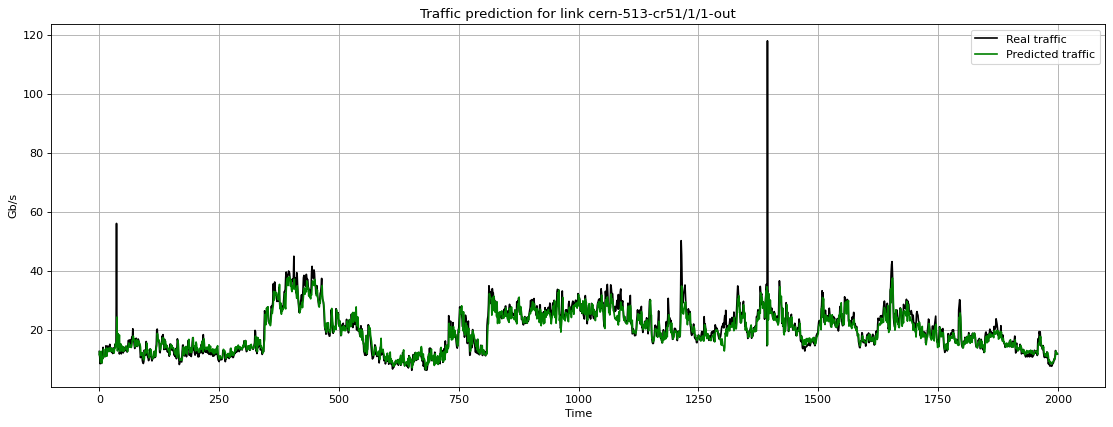

In [ ]:
dataset_test = dataset_test.reset_index()
dataset_test.drop(['index'], axis=1, inplace=True)
for i, col in enumerate(dataset_test.columns):

  curr_preds = []
  for val in preds:
    curr_preds.append(val[i])


  plt.figure(i)
  figure(figsize=(17, 6), dpi=80)
  plt.plot(dataset_test[col], color = 'black', label = 'Real traffic')
  plt.plot(curr_preds, color = 'green', label = 'Predicted traffic')
  plt.title('Traffic prediction for link ' + col)
  plt.xlabel('Time')
  plt.ylabel('Gb/s')
  plt.legend()
  plt.grid()
  plt.show()

In [ ]:
from sklearn.metrics import mean_squared_error

for i, col in enumerate(dataset_test.columns):


  curr_preds = []
  for val in preds:
    curr_preds.append(val[i])
  
  total_error = 0
  curr_error = mean_squared_error(dataset_test[col], curr_preds)
  total_error += curr_error
  print(col, ' error: ', curr_error)

print(color.BOLD , 'Mean error: ' , total_error/len(dataset_test.columns) , color.END)

cern-513-cr5to_cern_ip-a-in  error:  0.26271090650431395
cern-513-cr5to_cern_ip-a-out  error:  0.03946375487645567
amst-cr54/1/1-in  error:  1.3998839812816788
amst-cr54/1/1-out  error:  8.121682595760468
cern-513-cr56/2/1-in  error:  0.23248600067330905
cern-513-cr56/2/1-out  error:  0.6121955688475008
cern-513-cr51/1/1-in  error:  27.619572574117036
cern-513-cr51/1/1-out  error:  12.388504432318884
 Mean error:  1.5485630540398605 


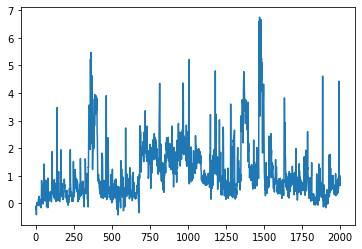

In [ ]:
preds5 = []
for val in preds:
  preds5.append(val[5])
plt.plot(preds5)

In [ ]:
preds5 = pd.Series(preds5)
preds5[preds5 > 4].index

Int64Index([ 359,  363,  365,  367,  368,  371,  813,  814,  966, 1007, 1179,
            1364, 1365, 1366, 1367, 1368, 1369, 1370, 1467, 1469, 1470, 1472,
            1473, 1474, 1475, 1476, 1477, 1478, 1479, 1480, 1481, 1482, 1483,
            1484, 1485, 1486, 1493, 1496, 1497, 1884, 1991],
           dtype='int64')

In [ ]:
act5 = dataset_test['amst-cr54/2/1-out']
act5[act5 > 6].index

Int64Index([ 358,  362,  462,  472,  965, 1006, 1178, 1466, 1469, 1478, 1481,
            1484, 1485, 1883, 1990],
           dtype='int64')

In [ ]:
dataset_test

,cern-513-cr5to_cern_ip-a-in,cern-513-cr5to_cern_ip-a-out,amst-cr54/1/1-in,amst-cr54/1/1-out,amst-cr54/2/1-in,amst-cr54/2/1-out,cern-773-cr53/2/1-in,cern-773-cr53/2/1-out,cern-513-cr56/2/1-in,cern-513-cr56/2/1-out
0,0.002425,0.596857,0.760501,25.110244,7.074196,0.084606,4.065202,5.587507,0.097600,1.903807
1,0.002125,0.964784,0.677239,30.148013,6.699152,0.034362,4.118178,5.404728,0.094395,0.656107
2,0.002162,0.320429,0.687258,30.788540,4.366545,0.020901,4.512198,5.437837,0.122144,0.578154
3,0.002444,0.378731,0.828108,26.288673,5.342091,0.023184,5.277135,6.200064,0.122738,0.593813
4,0.003563,0.509837,0.733121,27.357045,4.760312,0.191357,5.718094,5.430619,0.076231,0.430919
...,...,...,...,...,...,...,...,...,...,...
1995,0.054386,0.387991,11.894783,26.936659,8.135226,0.188030,5.632476,3.654594,1.546903,0.062615
1996,0.146948,0.359041,10.438351,27.084509,8.770182,0.127706,5.564955,4.002445,0.862347,0.065928
1997,0.846153,0.279608,10.893182,27.573940,8.791793,0.124025,3.463116,3.654443,0.616082,0.070215
1998,0.814100,0.372761,11.275566,27.114040,10.422748,0.118193,2.398176,3.193486,0.559515,0.079424


In [ ]:
preds5

0      -0.205532
1      -0.100835
2      -0.121911
3      -0.207565
4      -0.411118
          ...   
1995    0.673538
1996    1.010308
1997    0.712130
1998    0.640020
1999    0.794063
Length: 2000, dtype: float64